Tutorial: VIC 5 Image Driver Parameter Conversion
====
***Converting parameters from ASCII VIC 4 format to netCDF VIC 5 Image Driver Format***

This Jupyter Notebook outlines one approach to converting VIC parameters from ASCII to netCDF format. For this tutorial, we'll convert three datasets from ASCII to netCDF:

1. **Livneh et al. (2015) - 1/16th deg. VIC parameters**
  - Description: http://www.colorado.edu/lab/livneh/data
  - Data: ftp://livnehpublicstorage.colorado.edu/public/Livneh.2015.NAmer.Dataset/nldas.vic.params/
  - Citation: Livneh B., E.A. Rosenberg, C. Lin, B. Nijssen, V. Mishra, K.M. Andreadis, E.P. Maurer, and D.P. Lettenmaier, 2013: A Long-term hydrologically based dataset of land surface fluxes and states for the conterminous United States: update and extensions, Journal of Climate, 26, 9384–9392.
2. **Global 1/2 deg. VIC parameters**
  - Description: http://www.hydro.washington.edu/SurfaceWaterGroup/Data/vic_global_0.5deg.html
  - Data: ftp://ftp.hydro.washington.edu/pub/HYDRO/data/VIC_param/vic_params_global_0.5deg.tgz
  - Citation: Nijssen, B.N., G.M. O'Donnell, D.P. Lettenmaier and E.F. Wood, 2001: Predicting the discharge of global rivers, J. Clim., 14(15), 3307-3323, doi: 10.1175/1520-0442(2001)014<3307:PTDOGR>2.0.CO;2.
3. **Maurer et al. (2002) - 1/8th deg. VIC parameters**
  - Description: http://www.hydro.washington.edu/SurfaceWaterGroup/Data/VIC_retrospective/index.html
  - Data: http://www.hydro.washington.edu/SurfaceWaterGroup/Data/VIC_retrospective/index.html
  - Citation: Maurer, E.P., A.W. Wood, J.C. Adam, D.P. Lettenmaier, and B. Nijssen, 2002: A long-term hydrologically-based data set of land surface fluxes and states for the conterminous United States, J. Climate 15, 3237-3251. 

All of these datasets include the following parameter sets:
- Soil Parameter file
- Vegetation Library file
- Vegetation Parameter file
- Snowbands file 

### Outputs
For each of the parameter sets above, we'll be producing two files:
1.  VIC 5 Image Driver Input Parameters (netCDF file defining model parameters)
2.  VIC 5 Image Driver Domain File (netCDF file defining spatial extent of model domain)

### Python Imports and Setup

In [1]:
%matplotlib inline

import os
import getpass
from datetime import datetime

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# For more information on tonic, see: https://github.com/UW-Hydro/tonic/
import tonic.models.vic.grid_params as gp

# Metadata to be used later
user = getpass.getuser()
now = datetime.now()

print('python version : %s' % os.sys.version)
print('numpy version  : %s' % np.version.full_version)
print('xarray version : %s' % xr.version.version)
print('User           : %s' % user)
print('Date/Time      : %s' % now)

python version : 3.5.1 |Continuum Analytics, Inc.| (default, Dec  7 2015, 11:24:55) 
[GCC 4.2.1 (Apple Inc. build 5577)]
numpy version  : 1.10.4
xarray version : 0.7.2
User           : jhamman
Date/Time      : 2016-06-08 15:01:23.814110


## Set Path Information

In [2]:
# Set the path to the datasets here
dpath = './'  # root input data path
opath = './'  # output data path
ldpath = os.path.join(dpath, 'Livneh_0.0625_NLDAS')  # Path to Livneh Parameters
gdpath = os.path.join(dpath, 'Nijssen_0.5_Global')  # Path to Global Parameters
mdpath = os.path.join(dpath, 'Maurer_0.125_NLDAS')  # Path to Maurer Parameters

# Livneh Domain File

Along with the VIC model parameters, we also need a domain file that describes the spatial extent and active grid cells in the model domain. The domain file must exactly match the parameters and forcings. The Livneh dataset includes a DEM file in netCDF format that we can use to construct the domain file.

Steps:

1. Open dem
2. Set useful global attributes
3. Create the mask/frac variables using the non-missing dem mask.
4. Calculate the grid cell area using `cdo`
5. Add the grid cell area back into the domain dataset.
6. Save the domain dataset

In [3]:
dom_file = os.path.join(opath, 'domain.vic.global0.0625deg.%s.nc' % now.strftime('%Y%m%d'))
dem = xr.open_dataset(os.path.join(ldpath, 'Composite.DEM.NLDAS.mex.0625.nc'))

dom_ds = xr.Dataset()

# Set global attributes
dom_ds.attrs['title'] = 'VIC domain data'
dom_ds.attrs['Conventions'] = 'CF-1.6'
dom_ds.attrs['history'] = 'created by %s, %s' % (user, now)
dom_ds.attrs['user_comment'] = 'VIC domain data'
dom_ds.attrs['source'] = 'generated from VIC North American 1/16 deg. model parameters, see Livneh et al. (2015) for more information'

# since we have it, put the elevation in the domain file
dom_ds['elev'] = dem['Band1']
dom_ds['elev'].attrs['long_name'] = 'gridcell_elevation'
dom_ds['elev'].attrs['units'] = 'm'

# Get the mask variable
dom_ds['mask'] = dem['Band1'].notnull().astype(np.int)
dom_ds['mask'].attrs['long_name'] = 'domain mask'
dom_ds['mask'].attrs['comment'] = '0 indicates cell is not active'

# For now, the frac variable is going to be just like the mask
dom_ds['frac'] = dom_ds['mask'].astype(np.float)
dom_ds['frac'].attrs['long_name'] = 'fraction of grid cell that is active'
dom_ds['frac'].attrs['units'] = '1'
    
# Save the output domain to a temporary file.
dom_ds.to_netcdf('temp.nc')
dom_ds.close()

In [4]:
# This shell command uses cdo step calculates the grid cell area
!cdo -O gridarea temp.nc area.nc
!rm temp.nc

cdo gridarea:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100%                  cdo gridarea: Processed 3 variables ( 0.63s )


<xarray.Dataset>
Dimensions:  (lat: 614, lon: 928)
Coordinates:
  * lon      (lon) float64 -125.0 -124.9 -124.8 -124.8 -124.7 -124.7 -124.6 ...
  * lat      (lat) float64 14.66 14.72 14.78 14.84 14.91 14.97 15.03 15.09 ...
Data variables:
    elev     (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    frac     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    area     (lat, lon) float64 4.673e+07 4.673e+07 4.673e+07 4.673e+07 ...
Attributes:
    title: VIC domain data
    Conventions: CF-1.6
    history: created by jhamman, 2016-06-08 15:01:23.814110
    user_comment: VIC domain data
    source: generated from VIC North American 1/16 deg. model parameters, see Livneh et al. (2015) for more information


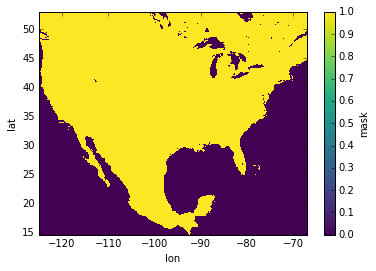

In [5]:
# This step extracts the area from the temporary area.nc file
area = xr.open_dataset('area.nc')['cell_area']
dom_ds['area'] = area

# Write the final domain file
dom_ds.to_netcdf(dom_file)
dom_ds.close()

# Document the domain and plot
print(dom_ds)
dom_ds['mask'].plot()

# Livneh Parameters

VIC 5 uses the same parameters as VIC 4. The following steps will read/parse the ASCII formatted parameter files and construct the netCDF formatted parameter file.  We'll use the domain file constructed in the previous step to help define the spatial grid.

Steps:

1. Read the soil/snow/veg/veglib files
2. Read the target grid (domain file)
3. Map the parameters to the spatial grid defined by the domain file
4. Write the parameters to a netCDF file.

In [6]:
soil_file = os.path.join(ldpath, 'vic.nldas.mexico.soil.txt')
snow_file = os.path.join(ldpath, 'vic.nldas.mexico.snow.txt.L13')
veg_file = os.path.join(ldpath, 'vic.nldas.mexico.veg.txt')
vegl_file = os.path.join(ldpath, 'LDAS_veg_lib')
out_file = os.path.join(opath, 'livneh_nldas.mexico_vic_5.0.0_parameters.nc')

# Set options that define the shape/type of parameters
cols = gp.Cols(nlayers=3,
               snow_bands=5,
               organic_fract=False,
               spatial_frost=False,
               spatial_snow=False,
               july_tavg_supplied=False,
               veglib_fcan=False,
               veglib_photo=False)
n_veg_classes = 11
vegparam_lai = True
lai_src = 'FROM_VEGPARAM'

# ----------------------------------------------------------------- #

# Read the soil parameters
soil_dict = gp.soil(soil_file, c=gp.Cols(nlayers=3))

# Read the snow parameters
snow_dict = gp.snow(snow_file, soil_dict, c=cols)

# Read the veg parameter file
veg_dict = gp.veg(veg_file, soil_dict,
                  vegparam_lai=vegparam_lai, lai_src=lai_src, 
                  veg_classes=n_veg_classes)

# Read the veg library file
veg_lib, lib_bare_idx = gp.veg_class(vegl_file, c=cols)

# Determine the grid shape
target_grid, target_attrs = gp.read_netcdf(dom_file)
for old, new in [('lon', 'xc'), ('lat', 'yc')]:
    target_grid[new] = target_grid.pop(old)
    target_attrs[new] = target_attrs.pop(old)

# Grid all the parameters
grid_dict = gp.grid_params(soil_dict,
                           target_grid,
                           version_in='4.1.2.c', 
                           vegparam_lai=vegparam_lai,
                           lib_bare_idx=lib_bare_idx, 
                           lai_src=lai_src,
                           veg_dict=veg_dict,
                           veglib_dict=veg_lib, 
                           snow_dict=snow_dict,
                           lake_dict=None)

# Write a netCDF file with all the parameters
gp.write_netcdf(out_file, 
                target_attrs,
                target_grid=target_grid,
                vegparam_lai=vegparam_lai,
                lai_src=lai_src, 
                soil_grid=grid_dict['soil_dict'],
                snow_grid=grid_dict['snow_dict'],
                veg_grid=grid_dict['veg_dict'])

reading ./Livneh_0.0625_NLDAS/vic.nldas.mexico.soil.txt
reading ./Livneh_0.0625_NLDAS/vic.nldas.mexico.snow.txt.L13
reading ./Livneh_0.0625_NLDAS/vic.nldas.mexico.veg.txt
reading ./Livneh_0.0625_NLDAS/LDAS_veg_lib
Reading input data variables:  odict_keys(['lon', 'lat', 'elev', 'mask', 'frac', 'area']) from file: ./domain.vic.global0.0625deg.20160608.nc
gridding params now...
creating 2d coordinate arrays
236213 masked values
dont have units or description for elev
writing var: run_cell
writing var: gridcell
writing var: lats
writing var: lons
writing var: infilt
writing var: Ds
writing var: Dsmax
writing var: Ws
writing var: c
writing var: expt
writing var: Ksat
writing var: phi_s
writing var: init_moist
writing var: elev
writing var: depth
writing var: avg_T
writing var: dp
writing var: bubble
writing var: quartz
writing var: bulk_density
writing var: soil_density
writing var: off_gmt
writing var: Wcr_FRACT
writing var: Wpwp_FRACT
writing var: rough
writing var: snow_rough
writing va

# Global 1/2 deg. Parameters

For the global 1/2 deg. parameters, we will follow the same steps as for the Livneh case with one exception. We don't have a domain file this time so we'll use `tonic`'s `calc_grid` function to make one for us.

In [7]:
soil_file = os.path.join(gdpath, 'global_soil_param_new')
snow_file = os.path.join(gdpath, 'global_snowbands_new')
veg_file = os.path.join(gdpath, 'global_veg_param_new')
vegl_file = os.path.join(gdpath, 'world_veg_lib.txt')
out_file = os.path.join(gdpath, 'global_0.5deg.vic_5.0.0_parameters.nc')

# Set options that define the shape/type of parameters
cols = gp.Cols(nlayers=3,
               snow_bands=5,
               organic_fract=False,
               spatial_frost=False,
               spatial_snow=False,
               july_tavg_supplied=False,
               veglib_fcan=False,
               veglib_photo=False)
n_veg_classes = 11
root_zones = 2
vegparam_lai = True
lai_src = 'FROM_VEGPARAM'

# ----------------------------------------------------------------- #

# Read the soil parameters
soil_dict = gp.soil(soil_file, c=cols)

# Read the snow parameters
snow_dict = gp.snow(snow_file, soil_dict, c=cols)

# Read the veg parameter file
veg_dict = gp.veg(veg_file, soil_dict,
                  vegparam_lai=vegparam_lai, lai_src=lai_src, 
                  veg_classes=n_veg_classes, max_roots=root_zones)

# Read the veg library file
veg_lib, lib_bare_idx = gp.veg_class(vegl_file, c=cols)

# Determine the grid shape
target_grid, target_attrs = gp.calc_grid(soil_dict['lats'], soil_dict['lons'])

# Grid all the parameters
grid_dict = gp.grid_params(soil_dict, target_grid, version_in='4', 
                           vegparam_lai=vegparam_lai, lai_src=lai_src,
                           lib_bare_idx=lib_bare_idx, 
                           veg_dict=veg_dict, veglib_dict=veg_lib, 
                           snow_dict=snow_dict, lake_dict=None)

# Write a netCDF file with all the parameters
gp.write_netcdf(out_file,
                target_attrs,
                target_grid=target_grid,
                vegparam_lai=vegparam_lai,
                lai_src=lai_src,
                soil_grid=grid_dict['soil_dict'],
                snow_grid=grid_dict['snow_dict'],
                veg_grid=grid_dict['veg_dict'])

reading ./Nijssen_0.5_Global/global_soil_param_new
reading ./Nijssen_0.5_Global/global_snowbands_new
reading ./Nijssen_0.5_Global/global_veg_param_new
reading ./Nijssen_0.5_Global/world_veg_lib.txt
Calculating grid size now...
found 717 unique lons
found 278 unique lats
assuming grid is meant to be global...
creating 2d coordinate arrays
Created a target grid based on the lats and lon in the soil parameter file
Grid Size: (360, 720)
gridding params now...
creating 2d coordinate arrays
197855 masked values
writing var: run_cell
writing var: gridcell
writing var: lats
writing var: lons
writing var: infilt
writing var: Ds
writing var: Dsmax
writing var: Ws
writing var: c
writing var: expt
writing var: Ksat
writing var: phi_s
writing var: init_moist
writing var: elev
writing var: depth
writing var: avg_T
writing var: dp
writing var: bubble
writing var: quartz
writing var: bulk_density
writing var: soil_density
writing var: off_gmt
writing var: Wcr_FRACT
writing var: Wpwp_FRACT
writing var:

# Global Domain File

Since the global soil parameters didn't come with a domain file that we could use, we'll construct one using the output from `tonic`'s `calc_grid` function. 

In [8]:
dom_ds = xr.Dataset()

# Set global attributes
dom_ds.attrs['title'] = 'VIC domain data'
dom_ds.attrs['Conventions'] = 'CF-1.6'
dom_ds.attrs['history'] = 'created by %s, %s' % (user, now)
dom_ds.attrs['user_comment'] = 'VIC domain data'
dom_ds.attrs['source'] = 'generated from VIC Global 0.5 deg. model parameters, see Nijssen et al. (2001) for more information'

In [9]:
dom_file = os.path.join(opath, 'domain.vic.global0.5deg.%s.nc' % now.strftime('%Y%m%d'))

# Get the mask variable
dom_ds['mask'] = xr.DataArray(target_grid['mask'], coords={'lat': target_grid['yc'],
                                                                 'lon': target_grid['xc']},
                                    dims=('lat', 'lon', ))

# For now, the frac variable is going to be just like the mask
dom_ds['frac'] = dom_ds['mask'].astype(np.float)
dom_ds['frac'].attrs['long_name'] = 'fraction of grid cell that is active'
dom_ds['frac'].attrs['units'] = '1'

# Set variable attributes
for k, v in target_attrs.items():
    if k == 'xc':
        k = 'lon'
    elif k == 'yc':
        k = 'lat'
    dom_ds[k].attrs = v
    
# Write temporary file for gridarea calculation
dom_ds.to_netcdf('temp.nc')

In [10]:
# This step calculates the grid cell area
!cdo -O gridarea temp.nc area.nc
!rm temp.nc

cdo gridarea:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100%                  cdo gridarea: Processed 2 variables ( 0.28s )


<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float64 -89.75 -89.25 -88.75 -88.25 -87.75 -87.25 -86.75 ...
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 -177.8 -177.2 -176.8 ...
Data variables:
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    frac     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    area     (lat, lon) float64 nan nan nan nan nan nan nan nan nan nan nan ...
Attributes:
    title: VIC domain data
    Conventions: CF-1.6
    history: created by jhamman, 2016-06-08 15:01:23.814110
    user_comment: VIC domain data
    source: generated from VIC Global 0.5 deg. model parameters, see Nijssen et al. (2001) for more information


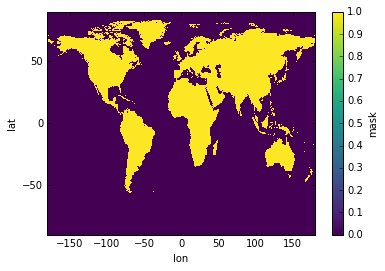

In [11]:
# Extract the area variable
area = xr.open_dataset('area.nc').load()['cell_area']
dom_ds['area'] = area

# write the domain file
dom_ds.to_netcdf(dom_file)
dom_ds.close()

# document and plot the domain
print(dom_ds)
dom_ds.mask.plot()

In [12]:
!rm area.nc

# Maurer 1/8 deg. Parameters

Finally, we'll repeat the same steps for the Maurer 1/8 deg. parameters.

In [13]:
soil_file = os.path.join(mdpath, 'soil', 'us_all.soil.wsne')
snow_file = os.path.join(mdpath, 'snow', 'us_all.snowbands.wsne')
veg_file = os.path.join(mdpath, 'veg', 'us_all.veg.wsne')
vegl_file = os.path.join(ldpath, 'LDAS_veg_lib')  # from livneh
out_file = os.path.join(mdpath, 'nldas_0.125deg.vic_5.0.0_parameters.nc')

cols = gp.Cols(nlayers=3,
               snow_bands=5,
               organic_fract=False,
               spatial_frost=False,
               spatial_snow=False,
               july_tavg_supplied=False,
               veglib_fcan=False,
               veglib_photo=False)
n_veg_classes = 11
root_zones = 2
vegparam_lai = True
lai_src = 'FROM_VEGPARAM'


# ----------------------------------------------------------------- #

# Read the soil parameters
soil_dict = gp.soil(soil_file, c=cols)

# Read the snow parameters
snow_dict = gp.snow(snow_file, soil_dict, c=cols)

# Read the veg parameter file
veg_dict = gp.veg(veg_file, soil_dict,
                  vegparam_lai=vegparam_lai, lai_src=lai_src, 
                  veg_classes=n_veg_classes, max_roots=root_zones)

# Read the veg library file
veg_lib, lib_bare_idx = gp.veg_class(vegl_file, c=cols)

# Determine the grid shape
target_grid, target_attrs = gp.calc_grid(soil_dict['lats'], soil_dict['lons'])

# Grid all the parameters
grid_dict = gp.grid_params(soil_dict, target_grid, version_in='4', 
                           vegparam_lai=vegparam_lai, lai_src=lai_src,
                           lib_bare_idx=lib_bare_idx, 
                           veg_dict=veg_dict, veglib_dict=veg_lib, 
                           snow_dict=snow_dict, lake_dict=None)

# Write a netCDF file with all the parameters
gp.write_netcdf(out_file,
                target_attrs,
                target_grid=target_grid,
                vegparam_lai=vegparam_lai,
                lai_src=lai_src,
                soil_grid=grid_dict['soil_dict'],
                snow_grid=grid_dict['snow_dict'],
                veg_grid=grid_dict['veg_dict'])

reading ./Maurer_0.125_NLDAS/soil/us_all.soil.wsne
reading ./Maurer_0.125_NLDAS/snow/us_all.snowbands.wsne
reading ./Maurer_0.125_NLDAS/veg/us_all.veg.wsne
reading ./Livneh_0.0625_NLDAS/LDAS_veg_lib
Calculating grid size now...
found 462 unique lons
found 222 unique lats
creating 2d coordinate arrays
Created a target grid based on the lats and lon in the soil parameter file
Grid Size: (222, 462)
gridding params now...
creating 2d coordinate arrays
48547 masked values
writing var: run_cell
writing var: gridcell
writing var: lats
writing var: lons
writing var: infilt
writing var: Ds
writing var: Dsmax
writing var: Ws
writing var: c
writing var: expt
writing var: Ksat
writing var: phi_s
writing var: init_moist
writing var: elev
writing var: depth
writing var: avg_T
writing var: dp
writing var: bubble
writing var: quartz
writing var: bulk_density
writing var: soil_density
writing var: off_gmt
writing var: Wcr_FRACT
writing var: Wpwp_FRACT
writing var: rough
writing var: snow_rough
writing 

# 1/8 deg CONUS domain file

In [14]:
dom_ds = xr.Dataset()

# Set global attributes
dom_ds.attrs['title'] = 'VIC domain data'
dom_ds.attrs['Conventions'] = 'CF-1.6'
dom_ds.attrs['history'] = 'created by %s, %s' % (user, now)
dom_ds.attrs['user_comment'] = 'VIC domain data'
dom_ds.attrs['source'] = 'generated from VIC CONUS 1.8 deg model parameters, see Maurer et al. (2002) for more information'

dom_file = os.path.join(opath, 'domain.vic.conus0.0125deg.%s.nc' % now.strftime('%Y%m%d'))

# Get the mask variable
dom_ds['mask'] = xr.DataArray(target_grid['mask'], coords={'lat': target_grid['yc'],
                                                                 'lon': target_grid['xc']},
                                    dims=('lat', 'lon', ))

# For now, the frac variable is going to be just like the mask
dom_ds['frac'] = dom_ds['mask'].astype(np.float)
dom_ds['frac'].attrs['long_name'] = 'fraction of grid cell that is active'
dom_ds['frac'].attrs['units'] = '1'

# Set variable attributes
for k, v in target_attrs.items():
    if k == 'xc':
        k = 'lon'
    elif k == 'yc':
        k = 'lat'
    dom_ds[k].attrs = v
    
# Write temporary file for gridarea calculation
dom_ds.to_netcdf('temp.nc')

In [15]:
# This step calculates the grid cell area
!cdo -O gridarea temp.nc area.nc
!rm temp.nc

cdo gridarea:   0%  0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 92% 93% 94% 95% 96% 97% 98% 99%100%                  cdo gridarea: Processed 2 variables ( 0.12s )


<xarray.Dataset>
Dimensions:  (lat: 222, lon: 462)
Coordinates:
  * lat      (lat) float64 25.19 25.31 25.44 25.56 25.69 25.81 25.94 26.06 ...
  * lon      (lon) float64 -124.7 -124.6 -124.4 -124.3 -124.2 -124.1 -123.9 ...
Data variables:
    mask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    frac     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    area     (lat, lon) float64 1.748e+08 1.748e+08 1.748e+08 1.748e+08 ...
Attributes:
    title: VIC domain data
    Conventions: CF-1.6
    history: created by jhamman, 2016-06-08 15:01:23.814110
    user_comment: VIC domain data
    source: generated from VIC CONUS 1.8 deg model parameters, see Maurer et al. (2002) for more information


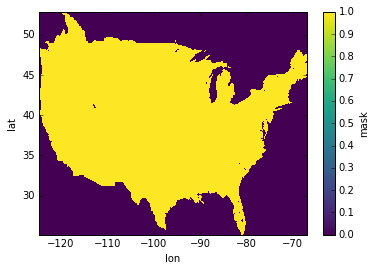

In [16]:
# Extract the area variable
area = xr.open_dataset('area.nc').load()['cell_area']
dom_ds['area'] = area

# write the domain file
dom_ds.to_netcdf(dom_file)
dom_ds.close()

# document and plot the domain
print(dom_ds)
dom_ds.mask.plot()

In [17]:
plt.close('all')